In [1]:
from easydict import EasyDict
import numpy as np

path_dict = EasyDict()

pcdata_path = './undistort/'
path_dict.odom_pc_path = pcdata_path + 'velodyne/odom.bin'
path_dict.raw_pc_path = path_dict.odom_pc_path.replace('odom', 'raw')
path_dict.last_frame_imu_path = pcdata_path + 'oxts/last_frame.txt'
path_dict.cur_frame_imu_path = path_dict.last_frame_imu_path.replace('last', 'cur')
path_dict.next_frame_imu_path = path_dict.last_frame_imu_path.replace('last', 'next')
path_dict.start_timestamp_path = pcdata_path + 'timestamps_start.txt'
path_dict.end_timestamp_path = path_dict.start_timestamp_path.replace('start', 'end')
path_dict.cur_timestamp_path = path_dict.start_timestamp_path.replace('_start', '')
path_dict.T_velo_imu_path = pcdata_path + 'calib_imu_to_velo.txt'
path_dict.T_cam_velo_path = pcdata_path + 'calib_velo_to_cam.txt'

print(path_dict.keys())

file_dict = EasyDict()
for keys in path_dict.keys():
    new_keys = keys.replace('path', 'file')
    if path_dict[keys][-3:] == 'bin':
        file_dict[new_keys] = np.fromfile(path_dict[keys], dtype=np.float32, count=-1)
    else:
        with open(path_dict[keys]) as file:
            file_dict[new_keys] = file.readlines()

print(file_dict.keys())

dict_keys(['odom_pc_path', 'raw_pc_path', 'last_frame_imu_path', 'cur_frame_imu_path', 'next_frame_imu_path', 'start_timestamp_path', 'end_timestamp_path', 'cur_timestamp_path', 'T_velo_imu_path', 'T_cam_velo_path'])
dict_keys(['odom_pc_file', 'raw_pc_file', 'last_frame_imu_file', 'cur_frame_imu_file', 'next_frame_imu_file', 'start_timestamp_file', 'end_timestamp_file', 'cur_timestamp_file', 'T_velo_imu_file', 'T_cam_velo_file'])


In [2]:
pc_frame_idx = 1
'''raw pc is distorted'''
raw_pc_data = file_dict['raw_pc_file'].reshape((-1, 4))
odom_pc_data = file_dict['odom_pc_file'].reshape((-1, 4))
xyz = raw_pc_data[:, :3]
'''read time'''
'''last--->start->cur->end--->next'''
timestamps = EasyDict()
for keys in file_dict.keys():
    if 'cur_timestamp' in keys:
        last_timestamp = file_dict[keys][pc_frame_idx - 1].split(' ')[1].split(':')[-2:]
        last_timestamp = float(last_timestamp[0]) * 60 + float(last_timestamp[1])
        next_timestamp = file_dict[keys][pc_frame_idx + 1].split(' ')[1].split(':')[-2:]
        next_timestamp = float(next_timestamp[0]) * 60 + float(next_timestamp[1])
        timestamps['last'] = last_timestamp
        timestamps['next'] = next_timestamp
    if 'timestamp' in keys:
        timestr = file_dict[keys][pc_frame_idx]
        timestr = timestr.split(' ')[1].split(':')[-2:]
        timestr = float(timestr[0]) * 60 + float(timestr[1])
        timestamps[keys.replace('_timestamp_file', '')] = timestr
timestamps['duration'] = timestamps.end - timestamps.start
print(timestamps)
'''read imu'''
'''last--->start?->cur->end?--->next'''


class imu_data():

    def __init__(self, imu_file):
        data = imu_file.split(' ')
        data = [float(x) for x in data]
        # print(data[8:23])
        self.roll, self.pitch, self.yaw = data[3:6]
        self.vf, self.vl, self.vu, self.ax, self.ay, self.az, self.af, self.al, self.au, self.wx, self.wy, self.wz, self.wf, self.wl, self.wu = data[
            8:23]
        self.R_w_imu = self.rpy2matrix(self.roll, self.pitch, self.yaw)

    def rpy2matrix(self, roll, pitch, yaw):
        # print(roll, pitch, yaw)
        x_roll = np.array([1, 0, 0, 0, np.cos(roll), -np.sin(roll), 0, np.sin(roll), np.cos(roll)]).reshape((3, 3))
        y_pitch = np.array([np.cos(pitch), 0, np.sin(pitch), 0, 1, 0, -np.sin(pitch), 0, np.cos(pitch)]).reshape((3, 3))
        z_yaw = np.array([np.cos(yaw), -np.sin(yaw), 0, np.sin(yaw), np.cos(yaw), 0, 0, 0, 1]).reshape((3, 3))
        rot_mat = z_yaw @ y_pitch @ x_roll
        return rot_mat


imu = EasyDict()
for keys in file_dict.keys():
    if 'frame_imu' in keys:
        imu[keys.replace('_frame_imu_file', '')] = imu_data(file_dict[keys][0])
print(imu)
'''read T'''
file = file_dict['T_velo_imu_file']
R_velo_imu = file[1].split(':')[1].split(' ')[1:]
R_velo_imu = np.array(R_velo_imu).reshape((3, 3))
t_velo_imu = file[2].split(':')[1].split(' ')[1:]
t_velo_imu = np.array(t_velo_imu).reshape((3, 1))
T_velo_imu = np.identity(4)
T_velo_imu[:3, :3] = R_velo_imu
T_velo_imu[:3, 3:4] = t_velo_imu
file = file_dict['T_cam_velo_file']
R_cam_velo = file[1].split(':')[1].split(' ')[1:]
R_cam_velo = np.array(R_cam_velo).reshape((3, 3))
t_cam_velo = file[2].split(':')[1].split(' ')[1:]
t_cam_velo = np.array(t_cam_velo).reshape((3, 1))
T_cam_velo = np.identity(4)
T_cam_velo[:3, :3] = R_cam_velo
T_cam_velo[:3, 3:4] = t_cam_velo
# print(T_velo_imu)

{'start': 3040.401385028, 'end': 3040.505543528, 'last': 3040.349304485, 'next': 3040.557622014, 'cur': 3040.453464278, 'duration': 0.10415850000026694}
{'last': <__main__.imu_data object at 0x7fb907169f70>, 'cur': <__main__.imu_data object at 0x7fb9071640a0>, 'next': <__main__.imu_data object at 0x7fb907164100>}


In [3]:
def rpy2matrix(roll, pitch, yaw):
    # print(roll, pitch, yaw)
    x_roll = np.array([1, 0, 0, 0, np.cos(roll), -np.sin(roll), 0, np.sin(roll), np.cos(roll)]).reshape((3, 3))
    y_pitch = np.array([np.cos(pitch), 0, np.sin(pitch), 0, 1, 0, -np.sin(pitch), 0, np.cos(pitch)]).reshape((3, 3))
    z_yaw = np.array([np.cos(yaw), -np.sin(yaw), 0, np.sin(yaw), np.cos(yaw), 0, 0, 0, 1]).reshape((3, 3))
    rot_mat = z_yaw @ y_pitch @ x_roll
    return rot_mat


def rpyt2T(rpy, trans):
    roll, pitch, yaw = rpy.reshape(-1)
    # print(roll, pitch, yaw)
    x_roll = np.array([1, 0, 0, 0, np.cos(roll), -np.sin(roll), 0, np.sin(roll), np.cos(roll)]).reshape((3, 3))
    y_pitch = np.array([np.cos(pitch), 0, np.sin(pitch), 0, 1, 0, -np.sin(pitch), 0, np.cos(pitch)]).reshape((3, 3))
    z_yaw = np.array([np.cos(yaw), -np.sin(yaw), 0, np.sin(yaw), np.cos(yaw), 0, 0, 0, 1]).reshape((3, 3))
    rot_mat = z_yaw @ y_pitch @ x_roll
    T = np.identity(4)
    T[:3, :3] = rot_mat
    T[:3, 3:4] = trans
    # print(T)
    return T


'''把每个扫描位置找出来'''
points_line = 2170
yaw = np.arctan2(xyz[:, 1], xyz[:, 0]) / np.pi
yaw = 0.5 * (yaw + 1) * points_line
yaw = yaw.astype(np.int32)
'''速度和角速度插值并积分，计算每个扫描位置的变换矩阵'''
last_vel = np.array([imu.last.vf, imu.last.vl, imu.last.vu]).reshape((3, 1)).astype(np.float32)
next_vel = np.array([imu.next.vf, imu.next.vl, imu.next.vu]).reshape((3, 1)).astype(np.float32)
cur_vel = np.array([imu.cur.vf, imu.cur.vl, imu.cur.vu]).reshape((3, 1)).astype(np.float32)
start_vel = ((timestamps.cur - timestamps.start) * cur_vel + (timestamps.start - timestamps.last) * last_vel) / (timestamps.cur - timestamps.last)
end_vel = ((timestamps.end - timestamps.cur) * cur_vel + (timestamps.next - timestamps.end) * next_vel) / (timestamps.next - timestamps.cur)
change_vel = end_vel - start_vel

last_w = np.array([imu.last.wf, imu.last.wl, imu.last.wu]).reshape((3, 1)).astype(np.float32)
next_w = np.array([imu.next.wf, imu.next.wl, imu.next.wu]).reshape((3, 1)).astype(np.float32)
cur_w = np.array([imu.cur.wf, imu.cur.wl, imu.cur.wu]).reshape((3, 1)).astype(np.float32)
start_w = ((timestamps.cur - timestamps.start) * cur_w + (timestamps.start - timestamps.last) * last_w) / (timestamps.cur - timestamps.last)
end_w = ((timestamps.end - timestamps.cur) * cur_w + (timestamps.next - timestamps.end) * next_w) / (timestamps.next - timestamps.cur)
change_w = end_w - start_w
dealt_t = (timestamps.end - timestamps.start) / points_line
print(dealt_t)
print('start_vel:', start_vel.T, 'end_vel:', end_vel.T)
T_imu_velo = np.linalg.inv(T_velo_imu)

moving_pos = np.identity(4)
mid_pos_idx = int((timestamps.cur - timestamps.start) / (timestamps.end - timestamps.start) * points_line)
T_0_midpos = np.identity(4)
for ang_idx in range(points_line):
    '''xyz_ang = xyz1[yaw == ang_idx]'''
    if ang_idx == 0:
        continue
    step_vel = start_vel + (ang_idx - 1) / (points_line - 1) * change_vel
    step_w = start_w + (ang_idx - 1) / (points_line - 1) * change_w
    step_t = step_vel * dealt_t
    # print(step_t.T)
    step_rpy = step_w * dealt_t
    moving_pos = moving_pos @ rpyt2T(step_rpy, step_t)
    if ang_idx == mid_pos_idx:
        T_0_midpos = moving_pos
# print(T_0_midpos)
T_midpos_0 = np.linalg.inv(T_0_midpos)
xyz1 = np.concatenate([xyz, np.ones((xyz.shape[0], 1))], axis=1).astype(np.float32)
xyz1 = (T_imu_velo @ xyz1.T).T
moving_pos = np.identity(4)
for ang_idx in range(points_line):
    '''xyz_ang = xyz1[yaw == ang_idx]'''
    if ang_idx == 0:
        continue
    step_vel = start_vel + (ang_idx - 1) / (points_line - 1) * change_vel
    step_w = start_w + (ang_idx - 1) / (points_line - 1) * change_w
    step_t = step_vel * dealt_t
    # print(step_t.T)
    step_rpy = step_w * dealt_t
    moving_pos = moving_pos @ rpyt2T(step_rpy, step_t)
    xyz1[yaw == ang_idx] = (T_midpos_0 @ moving_pos @ xyz1[yaw == ang_idx].T).T
    # print(moving_pos[:3, 3].T)

xyz1 = (T_velo_imu @ xyz1.T).T.astype(np.float32)
xyz1[:, 3:4] = raw_pc_data[:, 3:4]
print(xyz1)
print(raw_pc_data)
# np.savetxt('./rawpc.txt', raw_pc_data)
xyz1.tofile('./undistort/undistort.bin')


4.799930875588338e-05
start_vel: [[12.548827    0.03126346 -0.09542312]] end_vel: [[12.575661    0.03677307 -0.10566783]]
[[58.174232  14.760634   2.234635   0.       ]
 [58.078037  15.221655   2.235572   0.       ]
 [57.29464   15.208655   2.2095795  0.       ]
 ...
 [19.021057  -5.0426154 -9.082578   0.23     ]
 [19.037655  -4.9826093 -9.082595   0.       ]
 [19.027256  -4.9156017 -9.069614   0.       ]]
[[58.123 14.76   2.237  0.   ]
 [58.025 15.221  2.238  0.   ]
 [57.241 15.208  2.212  0.   ]
 ...
 [19.075 -5.042 -9.084  0.23 ]
 [19.091 -4.982 -9.084  0.   ]
 [19.08  -4.915 -9.071  0.   ]]


In [4]:
import open3d


mesh_frame = open3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=[0, 0, 0])

undistort_pcd = open3d.geometry.PointCloud()
undistort_pcd.points = open3d.utility.Vector3dVector(xyz1[:, :3])
undistort_color = np.zeros((xyz1.shape[0], 3)).astype(np.uint8)
undistort_color[:, 0] = 255
undistort_pcd.colors = open3d.utility.Vector3dVector(undistort_color)

raw_pcd = open3d.geometry.PointCloud()
raw_pcd.points = open3d.utility.Vector3dVector(raw_pc_data[:, :3])
raw_color = np.zeros((xyz1.shape[0], 3)).astype(np.uint8)
raw_color[:, 1] = 255
raw_pcd.colors = open3d.utility.Vector3dVector(raw_color)

odom_pcd = open3d.geometry.PointCloud()
odom_pcd.points = open3d.utility.Vector3dVector(odom_pc_data[:, :3])
odom_color = np.zeros((xyz1.shape[0], 3)).astype(np.uint8)
odom_color[:, 2] = 255
odom_pcd.colors = open3d.utility.Vector3dVector(odom_color)

vis_ = open3d.visualization.Visualizer()
vis_.create_window()
# vis_.add_geometry(undistort_pcd)
vis_.add_geometry(raw_pcd)
# vis_.add_geometry(odom_pcd)
vis_.add_geometry(mesh_frame)

render_options = vis_.get_render_option()
render_options.point_size = 1
render_options.background_color = np.array([0, 0, 0])
vis_.run()
vis_.destroy_window()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


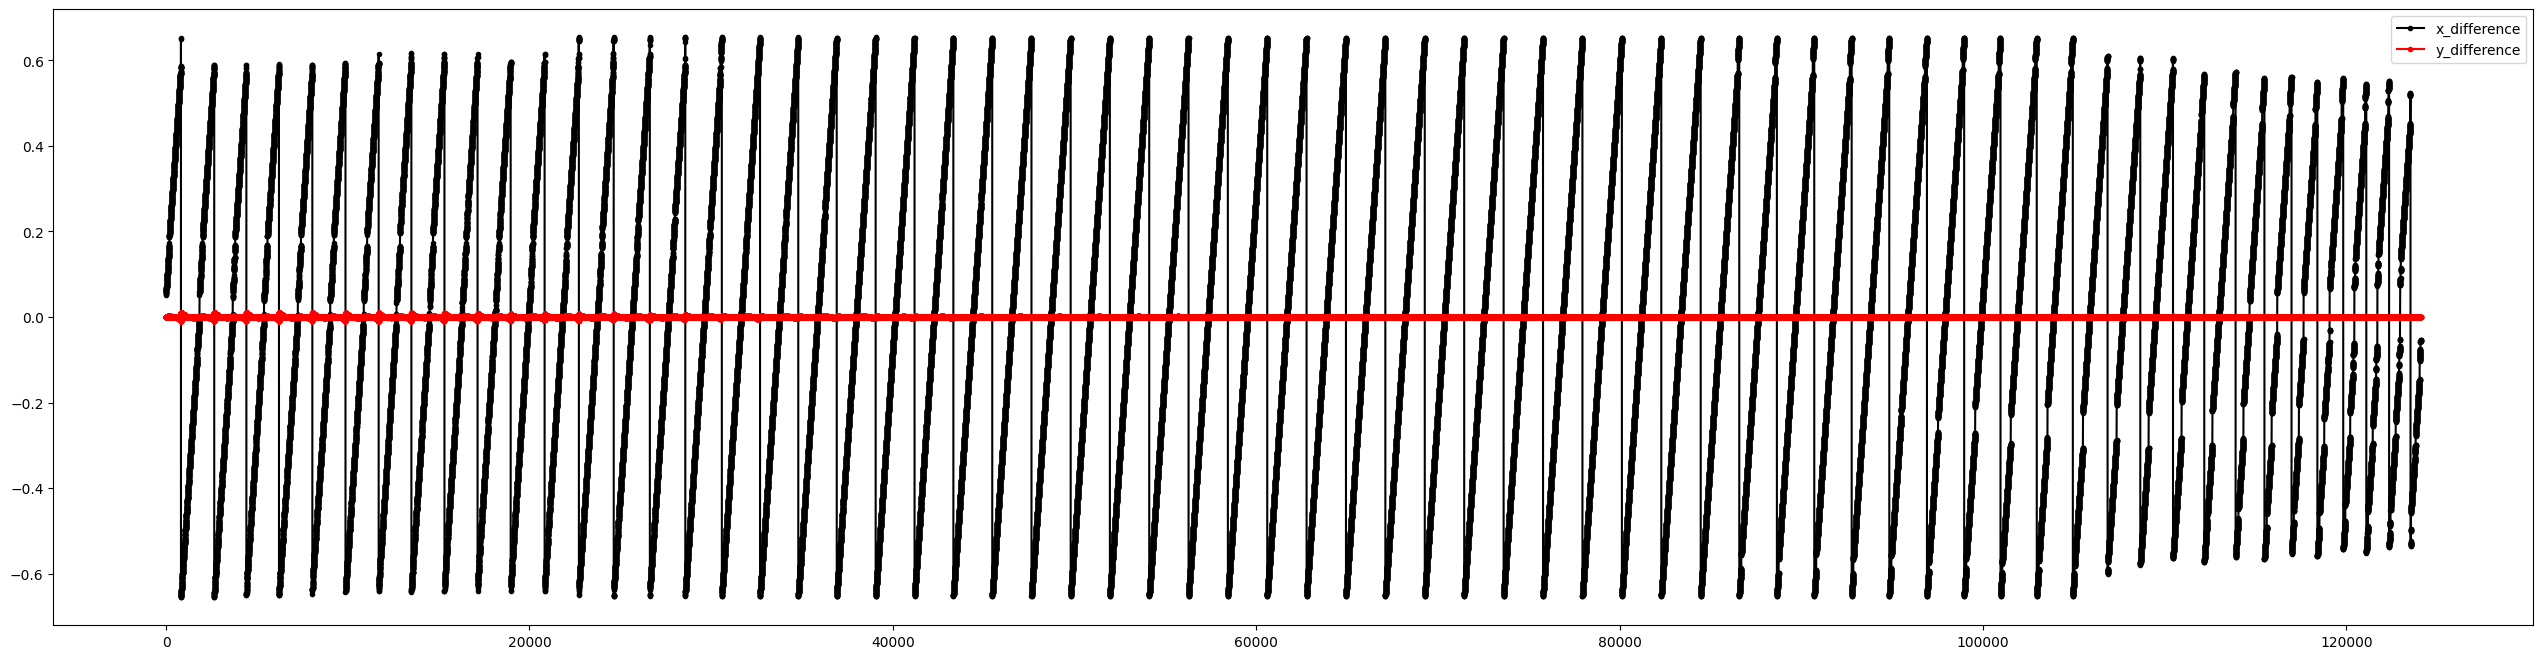

In [5]:
import matplotlib.pyplot as plt

x = range(xyz1.shape[0])
x_axis1 = xyz1[:, 0].reshape(-1)
x_axis2 = raw_pc_data[:, 0].reshape(-1)
y_axis1 = xyz1[:, 1].reshape(-1)
y_axis2 = raw_pc_data[:, 1].reshape(-1)
plt.figure(figsize=(32, 8))
# plt.plot(x, x_axis2, color='orange', marker='.', linestyle='-', label='raw')
# plt.plot(x, x_axis1, color='red', marker='.', linestyle='-', label='undistort')
plt.plot(x, x_axis1-x_axis2, color='black', marker='.', linestyle='-', label='x_difference')
plt.plot(x, y_axis1-y_axis2, color='red', marker='.', linestyle='-', label='y_difference')
plt.legend()
plt.show()

In [6]:
'''测试一圈点最多是2170个'''
calib_path = './config/calib.txt'
with open(calib_path) as calib_file:
    data = calib_file.readlines()
    T_xyz = data[3].split(':')[1].split(' ')[1:]
    T_xyz = np.array(T_xyz).reshape(4, 4).astype(np.float32)

xyz1 = np.concatenate([xyz, np.ones((xyz.shape[0], 1))], axis=1)
xyz = (T_xyz[:3, :] @ xyz1.T).T
pc_range = np.linalg.norm(xyz, axis=1)
pitch = np.arcsin(xyz[:, 2] / pc_range) / np.pi * 180
yaw = np.arctan2(-xyz[:, 1], -xyz[:, 0]) / np.pi
yaw = 0.5 * (yaw + 1)
jump_idx = ((yaw[1:] < 0.2) * (yaw[:-1] > 0.8))
jump_idx = np.nonzero(jump_idx)[0] + 1
jump = np.zeros_like(pitch).astype(np.uint32)
jump[jump_idx] = 1
jump = np.cumsum(jump).astype(np.uint32)
max_points = 0
for line in range(jump.max() + 1):
    cur_points = len(pitch[jump == line])
    if cur_points > max_points:
        max_points = cur_points
print(max_points)

2170


In [7]:
'''我需要测试一下kitti imu的数据'''
'''没测明白'''
import numpy as np

test_imu = imu.cur
T_w_imu = rpy2matrix(test_imu.roll, test_imu.pitch, test_imu.yaw)
acc_imu = np.array([test_imu.af, test_imu.al, -test_imu.au]).reshape((3, 1))
acc_w = np.array([test_imu.ax, test_imu.ay, -test_imu.az]).reshape((3, 1))
print(np.linalg.norm(acc_imu), np.linalg.norm(acc_w))
print(acc_w.T, acc_imu.T)
print((T_w_imu @ acc_w).T, (T_w_imu @ acc_imu).T)

w_imu = np.array([test_imu.wf, test_imu.wl, test_imu.wu]).reshape((3, 1))
w_w = np.array([test_imu.wx, test_imu.wy, test_imu.wz]).reshape((3, 1))
print(w_w.T, w_imu.T)
print((T_w_imu @ w_w).T, (T_w_imu @ w_imu).T)
print((T_velo_imu[:3,:3] @ w_w).T, (T_velo_imu[:3,:3] @ w_imu).T)


9.824537278878175 9.82448676513144
[[ 0.13319847  0.47141488 -9.81226612]] [[ 0.25125574  0.04701651 -9.82121137]]
[[-0.89372507 -0.09627098 -9.78327796]] [[-0.48658663  0.06965494 -9.8122329 ]]
[[0.00705257 0.01424293 0.00180041]] [[0.00708142 0.01415178 0.00233171]]
[[-0.01487547  0.00539783  0.00232921]] [[-0.01476612  0.00544642  0.00285561]]
[[0.00705964 0.01420914 0.00202564]] [[0.00708734 0.0141101  0.00255557]]
